<a href="https://colab.research.google.com/github/chunkanglu/Tetr.io-Rank-Predictor/blob/main/TetrioRankPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tetr.io Rank Predictor 

Goal: To predict Tetr.io rank based on other player statistics such as **APM (Attack-per-Minute)**, **PPS (Pieces-per-Second)**, and **VS Score**.

### Note: 
The comments here derive from the data taken on Februrary 2, 2021. Since this program collects the current live data, there may be variations in the results. 

In [ ]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV

Get Tetr.io Tetra League data from API

In [ ]:
full_data = requests.get("https://ch.tetr.io/api/users/lists/league/all")

Turn data from JSON file into a Pandas DataFrame. We only include the user data and disregard the rest.

In [ ]:
full_dic = json.loads(full_data.text)

all_players = []

working_dict = full_dict['data']['users']

for p in range(len(working_dict)): # For every player

  player = {}

  for a in working_dict[p]: # For every attribute of player

    if a != "league":

      player[a] = working_dict[p][a] # Add attributes that are not part of league

  for a in working_dict[p]["league"]:

    player[a] = working_dict[p]["league"][a]

  all_players.append(player)

df = pd.DataFrame(all_players, index=[i for i in range(len(all_players))])

# Optionally save to csv
# df.to_csv('TetrioAll.csv') 


'\nfull_dic = json.loads(full.text)\n\nall_players = []\n\n#print(full_dic[\'data\'][\'users\'].keys())\n\nworking_dic = full_dic[\'data\'][\'users\']\n\nfor p in range(len(working_dic)): #for every player\n\n  player = {}\n\n  for a in working_dic[p]: # for every attribute of player\n    if a != "league":\n      player[a] = working_dic[p][a] # add attributes that are not part of league\n\n  for a in working_dic[p]["league"]:\n    player[a] = working_dic[p]["league"][a]\n\n  all_players.append(player)\n\nfull_df = pd.DataFrame(all_players, index=[i for i in range(len(all_players))])\n\nfull_df.to_csv(\'TetrioAll.csv\')\n\nfrom google.colab import files\nfiles.download(\'TetrioALL.csv\')\n'

In [ ]:
df

,Unnamed: 0,_id,username,role,supporter,verified,country,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,decaying
0,0,5e844b0868270e617d52c990,czsmall0402,user,True,False,NaN,238,215,2.497863e+04,3363,84,x,146.55,3.19,321.62,False
1,1,5f5dbcc4454e942b4fdfc5fa,vincehd_,user,True,True,PH,162,149,2.497728e+04,3336,66,x,148.18,3.42,332.45,False
2,2,5e7cd9b6552a596c95f3c0a0,jason0107,user,NaN,False,TW,203,174,2.497106e+04,3273,67,x,146.11,3.63,323.59,False
3,3,6005c355413441e94a56c91f,seunghun1004,user,NaN,False,KR,105,96,2.496311e+04,3208,66,x,125.46,3.41,284.71,False
4,4,5eb11da1e47b643b5d12e5f1,gamaover,user,True,True,JP,332,245,2.496264e+04,3205,66,x,121.62,2.93,279.35,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14770,14770,5fe95de14529400ba470617e,shootinstar,user,NaN,False,US,49,4,2.324928e+02,272,83,d,2.65,0.51,6.33,True
14771,14771,5fdbade9e3ea3a3755f37ebf,sis25,user,NaN,False,AR,291,72,2.173199e+02,258,69,d,6.57,0.87,11.89,True
14772,14772,6013a88bf5c57ce9662953b5,ramsesin,user,NaN,False,MX,88,16,2.137163e+02,253,69,d,4.11,0.48,7.85,False
14773,14773,5e9d195ae6f1903fa6604b4f,slowandstupid,user,NaN,False,NaN,2973,10,3.966677e-49,-30511,80,d,0.00,0.01,NaN,True


In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14775 entries, 0 to 14774
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          14775 non-null  object 
 1   username     14775 non-null  object 
 2   role         14775 non-null  object 
 3   supporter    295 non-null    object 
 4   verified     14775 non-null  bool   
 5   country      14451 non-null  object 
 6   gamesplayed  14775 non-null  int64  
 7   gameswon     14775 non-null  int64  
 8   rating       14775 non-null  float64
 9   glicko       14775 non-null  int64  
 10  rd           14775 non-null  int64  
 11  rank         14775 non-null  object 
 12  apm          14775 non-null  float64
 13  pps          14775 non-null  float64
 14  vs           14773 non-null  float64
 15  decaying     14775 non-null  bool   
dtypes: bool(2), float64(4), int64(4), object(6)
memory usage: 1.6+ MB


I see there are 2 random rows in `vs` that have missing values so I drop them

In [ ]:
df.dropna(axis=0, subset=['vs'], inplace=True)

A `Z` in the rank column means unranked, so we also drop those rows as they don't provide value.

In [ ]:
df['rank'].value_counts()

a     1187
b-    1183
b     1182
a-    1181
a+    1157
b+    1147
s-    1039
c+     900
c      897
s+     886
ss     874
s      863
c-     761
u      597
d      378
d+     372
x      168
Name: rank, dtype: int64

In [ ]:
df = df[df['rank'] != 'z']

First, I try to map each rank into a numerical value. (This isn't the best solution as later on it shows that there are too many categories to predict and too few data)

In [ ]:
ranks = {'d': 1, 'd+': 2, 'c-': 3, 'c': 4, 'c+': 5, 'b-': 6, 'b': 7, 'b+': 8, 'a-': 9, 'a':10, 'a+': 11, 's-': 12, 's': 13, 's+': 14, 'ss': 15, 'u': 16, 'x': 17}
df['rank_num'] = df['rank'].map(ranks)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,_id,username,role,supporter,verified,country,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,decaying,rank_num
0,5e844b0868270e617d52c990,czsmall0402,user,True,False,NaN,238,215,24978.632540,3363,84,x,146.55,3.19,321.62,False,17
1,5f5dbcc4454e942b4fdfc5fa,vincehd_,user,True,True,PH,162,149,24977.281402,3336,66,x,148.18,3.42,332.45,False,17
2,5e7cd9b6552a596c95f3c0a0,jason0107,user,NaN,False,TW,203,174,24971.060275,3273,67,x,146.11,3.63,323.59,False,17
3,6005c355413441e94a56c91f,seunghun1004,user,NaN,False,KR,105,96,24963.111381,3208,66,x,125.46,3.41,284.71,False,17
4,5eb11da1e47b643b5d12e5f1,gamaover,user,True,True,JP,332,245,24962.642754,3205,66,x,121.62,2.93,279.35,False,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14768,5fc40de613e8c021da3a03fe,blindsixx,user,NaN,False,DO,101,13,234.876448,278,67,d,3.31,0.16,7.32,False,1
14769,5fed88f67222310b7a4fcc7b,rank_d,user,NaN,False,KR,26,0,234.794148,264,99,d,0.57,8.20,0.95,True,1
14770,5fe95de14529400ba470617e,shootinstar,user,NaN,False,US,49,4,232.492803,272,83,d,2.65,0.51,6.33,True,1
14771,5fdbade9e3ea3a3755f37ebf,sis25,user,NaN,False,AR,291,72,217.319911,258,69,d,6.57,0.87,11.89,True,1


The data is currently organized in descending order by rank. As this will cause problems when I later go to split the data into training and test sets, I shuffle the data around.

In [ ]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df, random_state=1)
df_shuffled = df_shuffled.reset_index(drop=True)
df_shuffled

,_id,username,role,supporter,verified,country,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,decaying,rank_num
0,5f607c56484fe92b48f63067,t3_sub,user,NaN,False,AU,62,24,1514.299275,779,94,c-,13.54,0.95,24.55,True,3
1,5fca67ab13e8c021da3b1a9c,water_t,user,NaN,False,CA,49,23,4921.120944,1131,76,b-,11.65,0.86,26.27,True,6
2,5fe01e0a194c617f9dea3d88,kingraf,user,NaN,False,US,246,126,19138.234100,1810,62,s,30.43,1.26,68.91,False,13
3,5fe46f882f7ee40b88d6f466,dzhd,user,NaN,False,RU,96,45,7681.431802,1287,63,b,12.32,0.88,26.38,False,7
4,5ed75205c866ed27dd1408a2,catgras,user,NaN,False,RO,326,152,9585.521157,1375,66,b+,15.23,0.90,30.22,False,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14767,5f3b3b25fdafc22e7e010648,coffeemugchii,user,NaN,False,NaN,482,268,22697.542517,2099,61,ss,46.55,1.60,110.26,False,15
14768,60073063413441e94a570e0e,toosavage,user,NaN,False,DE,345,178,14954.820443,1604,61,a+,20.13,1.03,43.21,False,11
14769,5ff33e4d1f4167321fd0de19,ritmo,user,NaN,False,TW,302,152,3398.425110,1016,62,c+,17.68,0.99,31.83,False,5
14770,5fa4c4b7985bcb97361bfca7,baizhou0205,user,NaN,False,CN,261,149,24212.666688,2400,76,u,77.46,2.24,172.28,True,16


Here I get the data that can possibly be used in training a model

In [ ]:
main_df = df_shuffled.loc[:,"gamesplayed":"vs"]
main_df["rank_num"] = df_shuffled["rank_num"]
main_df

,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,rank_num
0,62,24,1514.299275,779,94,c-,13.54,0.95,24.55,3
1,49,23,4921.120944,1131,76,b-,11.65,0.86,26.27,6
2,246,126,19138.234100,1810,62,s,30.43,1.26,68.91,13
3,96,45,7681.431802,1287,63,b,12.32,0.88,26.38,7
4,326,152,9585.521157,1375,66,b+,15.23,0.90,30.22,8
...,...,...,...,...,...,...,...,...,...,...
14767,482,268,22697.542517,2099,61,ss,46.55,1.60,110.26,15
14768,345,178,14954.820443,1604,61,a+,20.13,1.03,43.21,11
14769,302,152,3398.425110,1016,62,c+,17.68,0.99,31.83,5
14770,261,149,24212.666688,2400,76,u,77.46,2.24,172.28,16


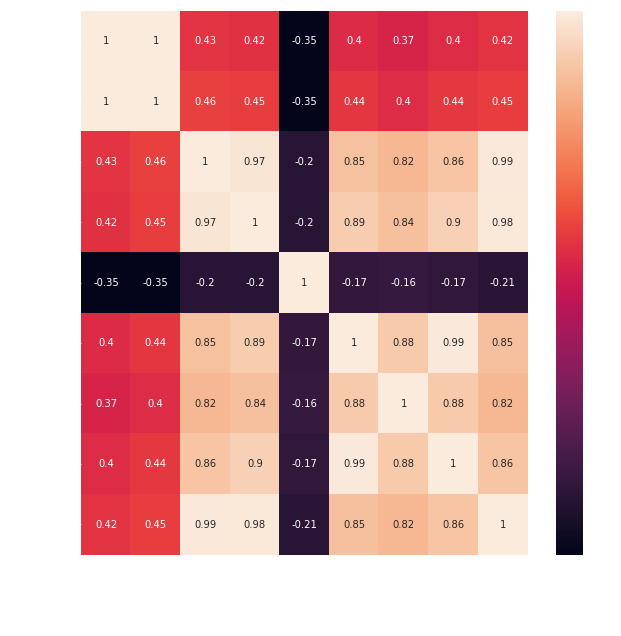

In [ ]:
corr_mat = main_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, annot=True)

We can't use rating, glicko, rd, since they directly determine rank.

---



Text(0.5, 1.0, 'Rank vs APM')

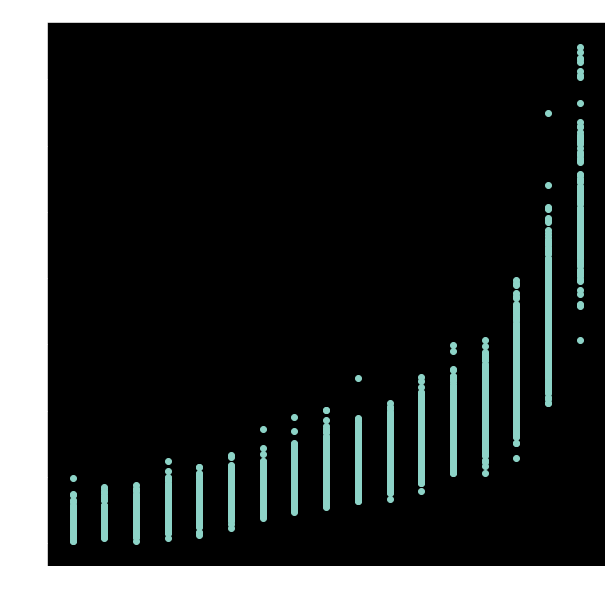

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(main_df.rank_num, main_df.apm)
ax.set_xlabel("Numerical Rank")
ax.set_ylabel("Attack Per Minute")
ax.set_title("Rank vs APM")

Text(0.5, 1.0, 'Rank vs PPS')

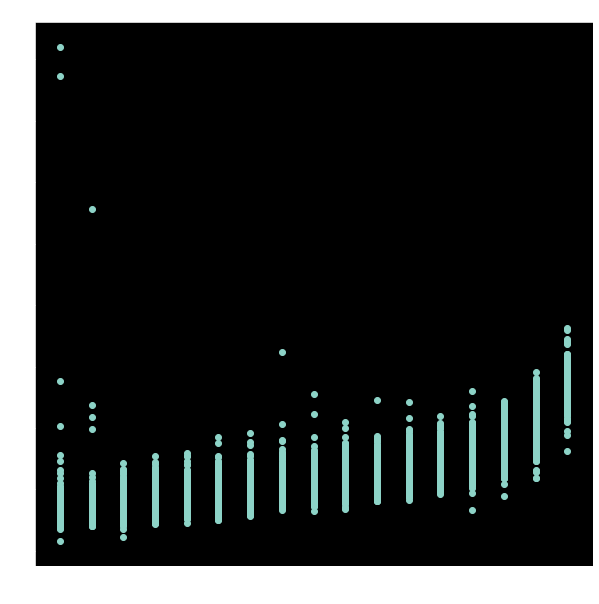

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(main_df.rank_num, main_df.pps)
ax.set_xlabel("Numerical Rank")
ax.set_ylabel("Pieces Per Second")
ax.set_title("Rank vs PPS")

We can see servere outliers in the above 5 pps yet d-tier range

In [ ]:
main_df[main_df.pps > 5]

,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,rank_num
7823,26,0,234.794148,264,99,d,0.57,8.20,0.95,1
9131,50,1,235.853265,279,86,d,5.70,7.73,10.38,1
11771,18,3,1042.000148,671,91,d+,15.27,5.57,25.71,2


Text(0.5, 1.0, 'Rank vs VS')

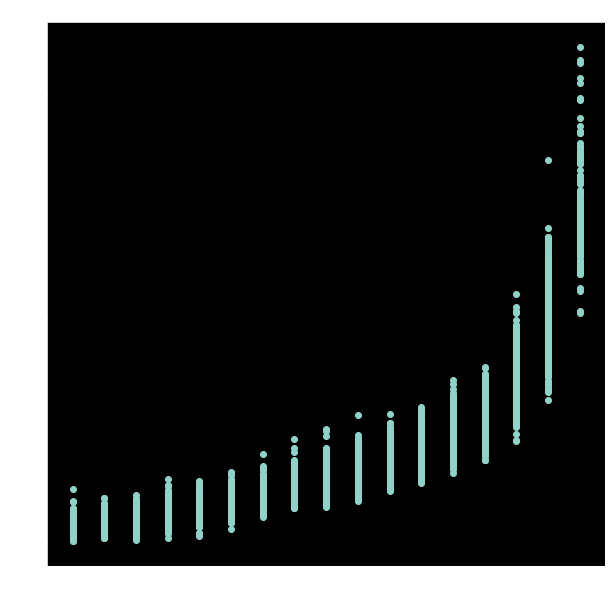

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(main_df.rank_num, main_df.vs)
ax.set_xlabel("Numerical Rank")
ax.set_ylabel("VS Score")
ax.set_title("Rank vs VS")

Remove the pps outliers

In [ ]:
main_df = main_df[main_df.pps < 5]

Text(0.5, 1.0, 'Rank vs PPS')

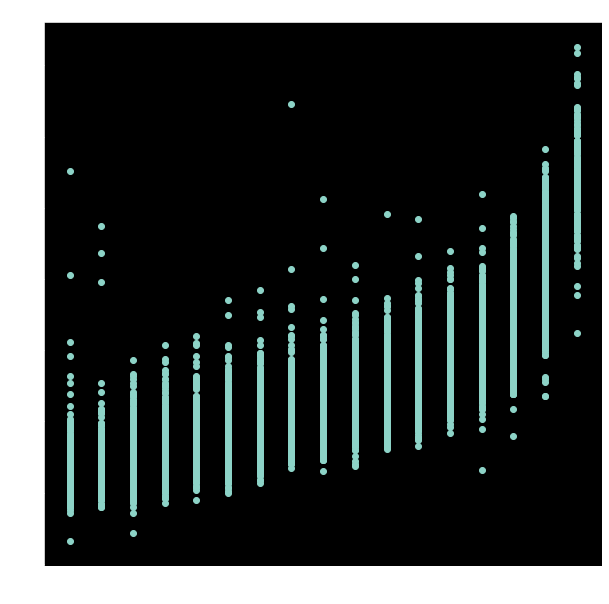

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(main_df.rank_num, main_df.pps)
ax.set_xlabel("Numerical Rank")
ax.set_ylabel("Pieces Per Second")
ax.set_title("Rank vs PPS")

Split the data into X & y for what I use to predict and what I want to predict.

In [ ]:
df_x = main_df.loc[:,['apm', 'pps', 'vs']]
df_x

,apm,pps,vs
0,13.54,0.95,24.55
1,11.65,0.86,26.27
2,30.43,1.26,68.91
3,12.32,0.88,26.38
4,15.23,0.90,30.22
...,...,...,...
14767,46.55,1.60,110.26
14768,20.13,1.03,43.21
14769,17.68,0.99,31.83
14770,77.46,2.24,172.28


In [ ]:
df_y = main_df['rank_num']
df_y

0         3
1         6
2        13
3         7
4         8
         ..
14767    15
14768    11
14769     5
14770    16
14771     3
Name: rank_num, Length: 14769, dtype: int64

Split the data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.7, random_state=1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10338, 3), (4431, 3), (10338,), (4431,))

Use the data to train 3 different classification models and see how they perform

In [ ]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):

  np.random.seed(42)

  model_scores = {}

  for name, model in models.items():

    model.fit(X_train, y_train)
    model_scores[name] = model.score(X_test, y_test)

  return model_scores

In [ ]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'KNN': 0.4287971112615662,
 'Logistic Regression': 0.2575039494470774,
 'Random Forest': 0.41931843827578424}

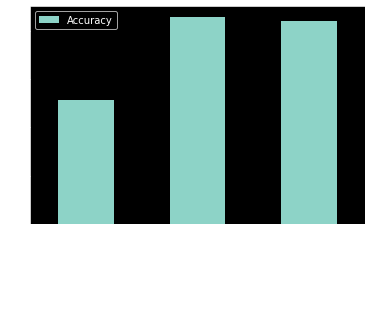

In [ ]:
scores_df = pd.DataFrame(model_scores, index=["Accuracy"])
scores_df.T.plot.bar()

As you can see, it's not doing too well as the highest accuracy is only 42%. I try to tune some hyperparameters to see if there is any change even though I don't expect much.

In [ ]:
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

# Tune RFC with RandomizedSearchCV

np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)

rs_rf.fit(X_train, y_train)


'\nrf_grid = {"n_estimators": np.arange(10,1000,50),\n           "max_depth": [None, 3, 5, 10],\n           "min_samples_split": np.arange(2,20,2),\n           "min_samples_leaf": np.arange(1,20,2)}\n\n#Tune RFC with RandomizedSearchCV\n\nnp.random.seed(42)\n\nrs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)\n\nrs_rf.fit(X_train, y_train)\n'

In [ ]:
rs_rf.best_params_

In [ ]:
rs_rf.score(X_test, y_test)

In [ ]:
model = RandomForestClassifier(max_depth=10, min_samples_leaf=9, min_samples_split=16, n_estimators=260)

In the end, it didn't improve too much. The model couldn't predict the specific ranks correctly most of the time due to many categories to predict as well as rather little distinction between some of the categories. For example, A-, A, and A+ are technically all pretty similar and belong to the same class. By this logic, let's generalize the ranks and merge some of them together. With this, I shrunk the number of categories from 17 to 8, halving the amount and most likely going to provide a significant increase in prediction accuracy.

I do everything like before to pre-process the data

In [ ]:
ranks_grouped = {'d': 1, 'd+': 1, 'c-': 2, 'c': 2, 'c+': 2, 'b-': 3, 'b': 3, 'b+': 3, 'a-': 4, 'a':4, 'a+': 4, 's-': 5, 's': 5, 's+': 5, 'ss': 6, 'u': 7, 'x': 8}
df['rank_grouped'] = df['rank'].map(ranks_grouped)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,_id,username,role,supporter,verified,country,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,decaying,rank_num,rank_grouped
0,5e844b0868270e617d52c990,czsmall0402,user,True,False,NaN,238,215,24978.632540,3363,84,x,146.55,3.19,321.62,False,17,8
1,5f5dbcc4454e942b4fdfc5fa,vincehd_,user,True,True,PH,162,149,24977.281402,3336,66,x,148.18,3.42,332.45,False,17,8
2,5e7cd9b6552a596c95f3c0a0,jason0107,user,NaN,False,TW,203,174,24971.060275,3273,67,x,146.11,3.63,323.59,False,17,8
3,6005c355413441e94a56c91f,seunghun1004,user,NaN,False,KR,105,96,24963.111381,3208,66,x,125.46,3.41,284.71,False,17,8
4,5eb11da1e47b643b5d12e5f1,gamaover,user,True,True,JP,332,245,24962.642754,3205,66,x,121.62,2.93,279.35,False,17,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14768,5fc40de613e8c021da3a03fe,blindsixx,user,NaN,False,DO,101,13,234.876448,278,67,d,3.31,0.16,7.32,False,1,1
14769,5fed88f67222310b7a4fcc7b,rank_d,user,NaN,False,KR,26,0,234.794148,264,99,d,0.57,8.20,0.95,True,1,1
14770,5fe95de14529400ba470617e,shootinstar,user,NaN,False,US,49,4,232.492803,272,83,d,2.65,0.51,6.33,True,1,1
14771,5fdbade9e3ea3a3755f37ebf,sis25,user,NaN,False,AR,291,72,217.319911,258,69,d,6.57,0.87,11.89,True,1,1


In [ ]:
df_shuffled = shuffle(df, random_state=1)
df_shuffled = df_shuffled.reset_index(drop=True)

In [ ]:
main_df = df_shuffled.loc[:,"gamesplayed":"vs"]
main_df["rank_grouped"] = df_shuffled["rank_grouped"]
main_df

,gamesplayed,gameswon,rating,glicko,rd,rank,apm,pps,vs,rank_grouped
0,62,24,1514.299275,779,94,c-,13.54,0.95,24.55,2
1,49,23,4921.120944,1131,76,b-,11.65,0.86,26.27,3
2,246,126,19138.234100,1810,62,s,30.43,1.26,68.91,5
3,96,45,7681.431802,1287,63,b,12.32,0.88,26.38,3
4,326,152,9585.521157,1375,66,b+,15.23,0.90,30.22,3
...,...,...,...,...,...,...,...,...,...,...
14767,482,268,22697.542517,2099,61,ss,46.55,1.60,110.26,6
14768,345,178,14954.820443,1604,61,a+,20.13,1.03,43.21,4
14769,302,152,3398.425110,1016,62,c+,17.68,0.99,31.83,2
14770,261,149,24212.666688,2400,76,u,77.46,2.24,172.28,7


In [ ]:
df_x = main_df.loc[:,['apm', 'pps', 'vs']]
df_x

,apm,pps,vs
0,13.54,0.95,24.55
1,11.65,0.86,26.27
2,30.43,1.26,68.91
3,12.32,0.88,26.38
4,15.23,0.90,30.22
...,...,...,...
14767,46.55,1.60,110.26
14768,20.13,1.03,43.21
14769,17.68,0.99,31.83
14770,77.46,2.24,172.28


In [ ]:
df_y = main_df.loc[:,"rank_grouped"]
df_y

0        2
1        3
2        5
3        3
4        3
        ..
14767    6
14768    4
14769    2
14770    7
14771    2
Name: rank_grouped, Length: 14772, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.7, random_state=1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10340, 3), (4432, 3), (10340,), (4432,))

In [ ]:
fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'KNN': 0.7578971119133574,
 'Logistic Regression': 0.6101083032490975,
 'Random Forest': 0.7630866425992779}

A significant increase in prediction accuracy from 42% up to 76%. I yet again tune hyperparameters to see if I can get slightly better results.

In [ ]:
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

#Tune RFC with RandomizedSearchCV

np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)

rs_rf.fit(X_train, y_train)


'\nrf_grid = {"n_estimators": np.arange(10,1000,50),\n           "max_depth": [None, 3, 5, 10],\n           "min_samples_split": np.arange(2,20,2),\n           "min_samples_leaf": np.arange(1,20,2)}\n\n#Tune RFC with RandomizedSearchCV\n\nnp.random.seed(42)\n\nrs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)\n\nrs_rf.fit(X_train, y_train)\n'

In [ ]:
rs_rf.best_params_

NameError: ignored

These parameters are what I got, and they may change as I use RandomizedSearchCV which does not check all possibilities. If I wanted to get the best possible model, GridSearchCV should be used.

In [ ]:
model = RandomForestClassifier(max_depth=None, min_samples_leaf=5, min_samples_split=12, n_estimators=310)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.7768501805054152

I wanted to see the deviation in the predicted values versus the actual values in terms of the prediction frequency. From the graph below, the predictions are on par with the actual values.

(array([ 217.,  749., 1063.,    0., 1054.,  857.,    0.,  269.,  175.,
          48.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

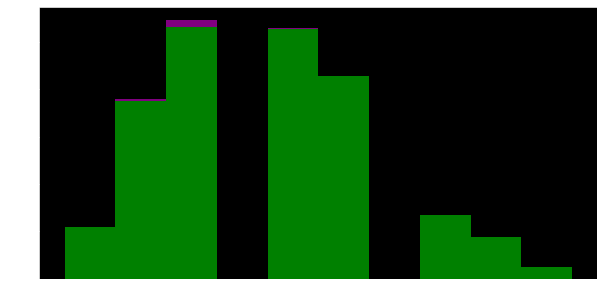

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(y_preds, color="purple")
plt.hist(y_test, color="green")

Just out of curiosity sake, I look to see some of the wrong predictions and see their differences. 

In [ ]:
compare = pd.DataFrame([y_preds, y_test], index=["Predicted", "Actual"]).T
compare

,Predicted,Actual
0,2,1
1,5,5
2,3,3
3,4,4
4,1,2
...,...,...
4427,4,4
4428,4,4
4429,5,5
4430,4,4


In [1]:
compare[compare.Predicted != compare.Actual]

NameError: ignored

As I expected, the wrong predictions are only off by 1 rank. 

### Afterthought

There was not too much data to begin with as Tetr.io is a rather small platform, so for what it is, the model did pretty decently. From the diagrams above, we could see that there wasn't a clear distinction between the ranks and there was a lot of overlap which directly affects prediction accuracy. I don't think the model could have done much better at its current state as the players in the data do not progress linearly in ranks aside their other statistics. Overall, 76% accuracy is pretty good considering all the problems that exist in this data. 

In [ ]:
"""
import pickle

pickle.dump(model,open("Tetrio_Model.sav", 'wb'))
"""